In [1]:
import numpy as np
import pandas as pd
import pickle
np.random.seed(42)
import scipy.stats as sps
import os

import matplotlib as mpl
mpl.use('Agg')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline


import pylab
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fave_cmap = mpl.cm.winter_r

import proclam
from proclam import *

In [2]:
M_classes = 13
flat_factor = 1. / M_classes

In [3]:
oom = 6
generator = proclam.simulators.LogUnbalanced()
N_objects = int(10 ** oom)
minitruth = generator.simulate(M_classes, N_objects, base=oom)
sklearn_truth = np.zeros((N_objects, M_classes))
for i, x in enumerate(minitruth):
    sklearn_truth[i][minitruth[i]] = 1
pops = np.histogram(minitruth, bins=range(M_classes+1))[0]
minipops = np.empty(M_classes)
for m in range(M_classes):
    minipops[m] = np.log10(np.max((pops[m], 1.))) /np.log10(N_objects)

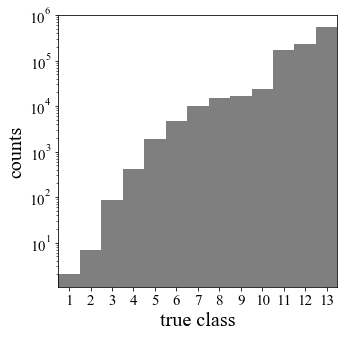

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
d = np.diff(np.unique(minitruth)).min()
left_of_first_bin = minitruth.min() - float(d)/2
right_of_last_bin = minitruth.max() + float(d)/2
ax.hist(minitruth, np.arange(left_of_first_bin, right_of_last_bin + d, d),\
        log=True, alpha=0.5, color='k')
ax.set_xticks(range(M_classes))
ax.set_xticklabels(range(1, M_classes+1))

ax.set_xlim(-0.5, M_classes-0.5)
ax.set_ylabel('counts', fontsize=20)
ax.set_xlabel('true class', fontsize=20)
plt.savefig('fig/mock_counts.png')
plt.show()
plt.close()

In [5]:
def make_cm(start_cm, m, systematic, accomplice=-1):
    cm = start_cm
    big_M = len(start_cm)
    if m < 0 or m > big_M:
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        return cm
    if systematic == 'uncertain':
        cm[m] = np.ones(big_M)
    if systematic == 'almost':
        cm[m] = flat_factor * 0.5 * np.ones(big_M)
        cm[m][m] += 1.5 * flat_factor
    if systematic == 'noisy':
        cm[m] = flat_factor * 0.5 * np.ones(big_M)
        cm[m][m] += 0.5 * flat_factor
    if systematic == 'perfect' or systematic == 'tunnel':
        cm[m] = flat_factor * np.zeros(big_M) + np.asarray(1.e-8)
        cm[:, m] = flat_factor * np.zeros(big_M).T + np.asarray(1.e-8)
        cm[m][m] += 1. * flat_factor
    if systematic == 'subsumed' or systematic == 'cruise':
        cm[m] = cm[accomplice]
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    return cm

In [6]:
classifier = proclam.classifiers.FromCM()

mega_test, alt_mega_test = {}, {}
N_affected = range(M_classes)

delfact = -1
minidelta = 10**delfact
altdelfact = delfact * 2
altminidelta = 10**altdelfact

metric_info = {'LogLoss': mpl.cm.winter_r(1.), 'LogLossSohier': mpl.cm.winter_r(0.)}
which_metrics = metric_info.keys()
met_evals = {}
for met in which_metrics:
    met_evals[met] = getattr(proclam.metrics, met)()

In [7]:
all_shapes = {'uncertain':'s', 'tunnel':'o', 'almost':'P', 'noisy':'X', 'subsumed': 'D', 'perfect': '*'}
all_shapes_bg = {'perfect':(3,0,0), 'almost':(4,0,0), 'noisy':(4,0,45)}
all_shapes_fg = {'uncertain':'.', 'almost':(4,2,0), 'noisy':(4,2,45), 'subsumed':(3,2,180)}

In [8]:
possible_weights = np.linspace(0., 1., 11)
weight_vecs = np.array([[i] + [(1. - i) / (M_classes - 1.)] * (M_classes - 1) for i in possible_weights])
which_weight_schemes = {str(i): weight_vecs[i] for i in range(len(possible_weights))}

fave_cmap = mpl.cm.winter_r

In [9]:
def cm_mega_plot(info_dict, systematics, m, fn='', numrows=2, numcols=4):
    fig = pylab.figure(figsize=(5.1, 5.1))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxes.set_title(fn+' with '+str(m)+' affected')
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(numrows,numcols),
                 axes_pad=0.,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.01,
                 )
    gridnos = np.arange(numrows * numcols).reshape((numcols, numrows)).T.flatten()
    for j in range(numcols * numrows):
        i = gridnos[j]
        ax = grid[j]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        position = ax.get_position()

        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)

        testname = systematics[j]
        
        im = ax.imshow(info_dict[testname]['cm'][m], vmin=0., vmax=1., cmap='winter_r')
        ax.text(.5,.9,testname,horizontalalignment='center',transform=ax.transAxes, fontsize=16)

    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    bigAxes.set_ylabel(r'true class', fontsize=20)
    bigAxes.set_xlabel(r'predicted class', fontsize=20)
    pylab.tight_layout()
    pylab.savefig('fig/systest_'+fn+'_cm.png', bbox_inches='tight', pad_inches=0)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


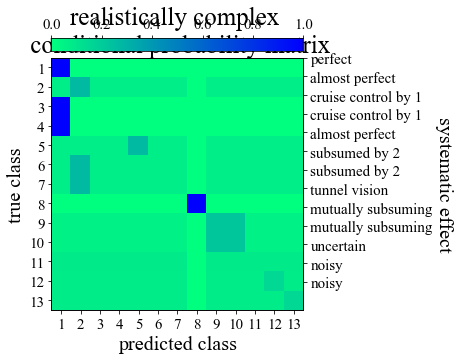

In [10]:
starter = 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
cm = starter


cruise = [0, 1]
subsumed = [2, 3, 5, 6]
swapped = [-4, -5]
tunnel = [0, 7]
noisy_cls = [-2, -1]
uncertain = [-3]
afflicted = cruise + subsumed + tunnel + noisy_cls

systematic_types = [
    'perfect',
    'almost perfect',
    'cruise control by 1',
    'cruise control by 1',
    'almost perfect',
    'subsumed by 2',
    'subsumed by 2',
    'tunnel vision',
    'mutually subsuming',
    'mutually subsuming',
    'uncertain',
    'noisy',
    'noisy'
]
plot_systematic_types = list(reversed(systematic_types))

almost = 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes)
almost = almost / np.sum(almost, axis=1)[:, np.newaxis]
cm = almost
perfect = np.eye(M_classes) + 1.e-8
cm[tunnel] = perfect[tunnel]
noisy = 0.5 * np.ones((M_classes, M_classes)) + 0.5 * np.eye(M_classes)
noisy = noisy / np.sum(starter, axis=1)[:, np.newaxis]
cm[noisy_cls] = noisy[noisy_cls]
cm[subsumed[:2]] = cm[cruise[0]]
cm[subsumed[2:]] = cm[cruise[1]]
cm[uncertain] = 1./float(M_classes) * np.ones(M_classes)
cm[swapped[1]][swapped[0]] = cm[swapped[0]][swapped[0]]
cm[swapped[0]][swapped[1]] = cm[swapped[1]][swapped[1]]
cm[:, 7] = perfect[:, 7]

cm = cm / np.sum(cm, axis=1)[:, np.newaxis]

print(np.sum(cm, axis=1))

fig = plt.figure(figsize=(5,5))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,1),
                 axes_pad=0.,
                 share_all=True,
                 cbar_location="top",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.1,
                 )
ax = grid[0]
im = ax.imshow(cm, vmin=0., vmax=1., cmap=mpl.cm.winter_r)
ax.set_xticks(range(M_classes))
ax.set_xticklabels(range(1, M_classes+1))
ax.set_yticks(range(M_classes))
ax.set_yticklabels(range(1, M_classes+1))

ax.set_ylabel('true class')
ax.set_xlabel('predicted class')
axp = ax.twinx()
axp.set_ylim(-0.5, M_classes-0.5)
axp.set_yticks(range(1, M_classes+1))
axp.set_yticklabels(plot_systematic_types)

axp.set_ylabel('systematic effect', rotation=270, labelpad=20)
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
ax.set_title('realistically complex \n conditional probability matrix')
plt.savefig('fig/combined.png')
plt.show()
plt.close()

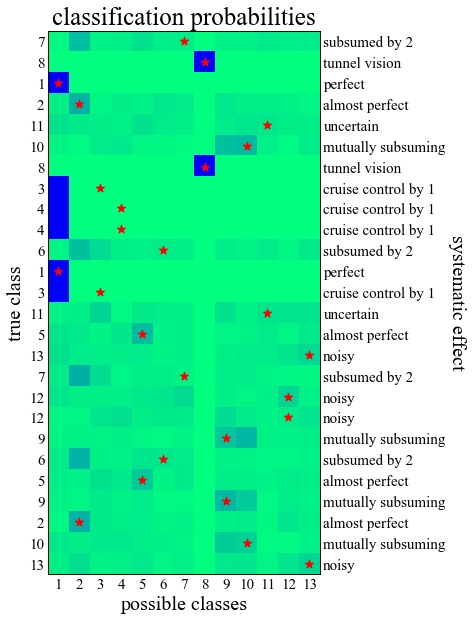

In [11]:
import random
from mpl_toolkits.axes_grid1 import ImageGrid

howmanytoshow = 2 * M_classes
truth_here = list(range(M_classes))+list(range(M_classes))#np.random.choice(M_classes, howmanytoshow)
random.shuffle(truth_here)
truth_here = np.array(truth_here)

classifier = FromCMDM()
res = classifier.classify(cm, truth_here, delta=0.01, other=False)

tickinfo = [systematic_types[i] for i in truth_here]
tickinfo = list(reversed(tickinfo))

fig = plt.figure(figsize=(5,10))
axs = ImageGrid(fig, 111, nrows_ncols=(1,1))
ax = axs[0]

ax.set_title('classification probabilities')
ax.set_xlabel('possible classes')
ax.set_xticks(range(M_classes))
ax.set_xticklabels(range(1, M_classes+1))

ax.imshow(res, vmin=0., vmax=1., cmap=mpl.cm.winter_r)
ax.set_yticks(range(howmanytoshow))
ax.set_yticklabels(truth_here+1)
ax.set_ylabel('true class')
ax.tick_params(axis=u'both', which=u'both',length=0)
for x, y in zip(truth_here, range(howmanytoshow)):
    ax.scatter(x, y, marker='*', color="red", s=75)#, fontsize=15)

ax2 = ax.twinx()
ax2.set_yticks(range(howmanytoshow))
ax2.set_yticklabels(tickinfo)
ax2.set_ylabel('systematic effect', rotation=270, labelpad=20)
ax2.set_ylim(-0.5, howmanytoshow-0.5)
ax2.tick_params(axis=u'both', which=u'both',length=0)

plt.savefig('fig/examples.png', dpi=250)
plt.show()

# test number affected by each systematic relative to different baselines

In [12]:
def one_loop_naff(collector, name, which_systematics, starter, dirichlet=False, fn=None):# mega_test, 'reltoagnostic'
    systest = {}
    if not dirichlet:
        classifier = FromCM()
        delta = minidelta
    else:
        classifier = FromCMDM()
        delta = altminidelta

    print('dirichlet='+str(dirichlet)+', delta='+str(delta))

    for s in which_systematics:
        systest[s] = {}
        for met in which_metrics:
            systest[s][met] = {}
            for w in which_weight_schemes:
                systest[s][met][w] = np.empty(M_classes+1)
        m = -1
        temp_cm = starter
        systest[s]['cm'] = np.empty((M_classes+1, M_classes, M_classes))

        temp_prob = classifier.classify(temp_cm, minitruth, delta=delta, other=False)

        isolated = range(N_objects)
        while m < M_classes:
            temp_cm = make_cm(temp_cm, m, s)
            systest[s]['cm'][m+1] = temp_cm
            temp_prob[isolated] = classifier.classify(temp_cm, minitruth[isolated], delta=delta, other=False)

            for met in which_metrics:
                D = met_evals[met]
                if met == 'LogLoss':
                    for w in which_weight_schemes.keys():
                        metval = D.evaluate(temp_prob, minitruth, averaging=which_weight_schemes[w])
                        systest[s][met][w][m+1] = metval
                else:
                    for w in which_weight_schemes.keys():
                        metval = D.evaluate(temp_prob, sklearn_truth, averaging=which_weight_schemes[w])
                        systest[s][met][w][m+1] = metval
                        
            thingtoprint = np.sum(np.ones(N_objects)[np.argmax(temp_prob, axis=1) == minitruth])
            print('how many would be right by MAP with systematic '+s+' and '+str(m+1)+' affected classes? '+
                    str(thingtoprint)+' or '+str(thingtoprint/float(N_objects)))
            m += 1
            isolated = np.where(minitruth == m)[0]

    collector[name] = systest
    if fn is not None:
        with open(fn, 'wb') as place:
            pickle.dump(collector, place)
    return collector

In [13]:
def load_collector(fn):
    with open(fn, 'rb') as place:
        collector = pickle.load(place)
    return collector

### Dirichlet perturbation

In [14]:
M_classes = 13
flat_factor = 1. / M_classes

oom = 6
generator = proclam.simulators.LogUnbalanced()
N_objects = int(10 ** oom)
minitruth = generator.simulate(M_classes, N_objects, base=oom)

sklearn_truth = np.zeros((N_objects, M_classes))
for i, x in enumerate(minitruth):
    sklearn_truth[i][minitruth[i]] = 1


pops = np.histogram(minitruth, bins=range(M_classes+1))[0]
minipops = np.empty(M_classes)
for m in range(M_classes):
    minipops[m] = np.log10(np.max((pops[m], 1.))) /np.log10(N_objects)

possible_weights = np.linspace(0., 1., 11)
weight_vecs = np.array([[i] + [(1. - i) / (M_classes - 1.)] * (M_classes - 1) for i in possible_weights])
which_weight_schemes = {str(i): weight_vecs[i] for i in range(len(possible_weights))}

fave_cmap = mpl.cm.winter_r
fn = 'fig/test'+str(M_classes)+'_fromcmdm.pkl'
if os.path.exists(fn):
    alt_mega_test = load_collector(fn)

## isolating the systematics with flat weights, relative to perfect

In [15]:
which_systematics = ['almost', 'noisy', 'uncertain', 'subsumed']
starter = np.eye(M_classes) + np.asarray(1.e-8)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
alt_mega_test = one_loop_naff(alt_mega_test, 'perfect', which_systematics, starter, dirichlet=True, fn='fig/test'+str(M_classes)+'_fromcmdm.pkl')

dirichlet=True, delta=0.01
how many would be right by MAP with systematic almost and 0 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic almost and 1 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic almost and 2 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic almost and 3 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic almost and 4 affected classes? 999999.0 or 0.999999
how many would be right by MAP with systematic almost and 5 affected classes? 999997.0 or 0.999997
how many would be right by MAP with systematic almost and 6 affected classes? 999987.0 or 0.999987
how many would be right by MAP with systematic almost and 7 affected classes? 999970.0 or 0.99997
how many would be right by MAP with systematic almost and 8 affected classes? 999936.0 or 0.999936
how many would be right by MAP with systematic almost and 9 affected classes? 999892.0 or 0.999892


## isolating the systematics with flat weights, relative to almost perfect

In [16]:
which_systematics = ['noisy', 'uncertain', 'subsumed']
starter = 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
alt_mega_test = one_loop_naff(alt_mega_test, 'almost', which_systematics,\
                              starter, dirichlet=True, fn='fig/test'+str(M_classes)+'_fromcmdm.pkl')

dirichlet=True, delta=0.01
how many would be right by MAP with systematic noisy and 0 affected classes? 997697.0 or 0.997697
how many would be right by MAP with systematic noisy and 1 affected classes? 997696.0 or 0.997696
how many would be right by MAP with systematic noisy and 2 affected classes? 997693.0 or 0.997693
how many would be right by MAP with systematic noisy and 3 affected classes? 997668.0 or 0.997668
how many would be right by MAP with systematic noisy and 4 affected classes? 997554.0 or 0.997554
how many would be right by MAP with systematic noisy and 5 affected classes? 996967.0 or 0.996967
how many would be right by MAP with systematic noisy and 6 affected classes? 995463.0 or 0.995463
how many would be right by MAP with systematic noisy and 7 affected classes? 992377.0 or 0.992377
how many would be right by MAP with systematic noisy and 8 affected classes? 987707.0 or 0.987707
how many would be right by MAP with systematic noisy and 9 affected classes? 982568.0 or 0.

## isolating the systematics with flat weights, relative to noisy

In [17]:
which_systematics = ['uncertain', 'subsumed']#['tunnel', 'almost', 'uncertain', 'subsumed']
starter = 0.5 * np.ones((M_classes, M_classes)) + 0.5 * np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
alt_mega_test = one_loop_naff(alt_mega_test, 'noisy', which_systematics, starter,\
                              dirichlet=True, fn='fig/test'+str(M_classes)+'_fromcmdm.pkl')

dirichlet=True, delta=0.01
how many would be right by MAP with systematic uncertain and 0 affected classes? 685232.0 or 0.685232
how many would be right by MAP with systematic uncertain and 1 affected classes? 685231.0 or 0.685231
how many would be right by MAP with systematic uncertain and 2 affected classes? 685228.0 or 0.685228
how many would be right by MAP with systematic uncertain and 3 affected classes? 685191.0 or 0.685191
how many would be right by MAP with systematic uncertain and 4 affected classes? 684946.0 or 0.684946
how many would be right by MAP with systematic uncertain and 5 affected classes? 683787.0 or 0.683787
how many would be right by MAP with systematic uncertain and 6 affected classes? 680860.0 or 0.68086
how many would be right by MAP with systematic uncertain and 7 affected classes? 674762.0 or 0.674762
how many would be right by MAP with systematic uncertain and 8 affected classes? 665639.0 or 0.665639
how many would be right by MAP with systematic uncertain

## isolating the systematics with flat weights, relative to uncertain

In [18]:
which_systematics = ['subsumed']#, 'tunnel']
starter = np.ones((M_classes, M_classes)) + 1.e-8
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
alt_mega_test = one_loop_naff(alt_mega_test, 'uncertain', which_systematics, starter,\
                              dirichlet=True, fn='fig/test'+str(M_classes)+'_fromcmdm.pkl')

dirichlet=True, delta=0.01
how many would be right by MAP with systematic subsumed and 0 affected classes? 77337.0 or 0.077337
how many would be right by MAP with systematic subsumed and 1 affected classes? 77337.0 or 0.077337
how many would be right by MAP with systematic subsumed and 2 affected classes? 77337.0 or 0.077337
how many would be right by MAP with systematic subsumed and 3 affected classes? 77338.0 or 0.077338
how many would be right by MAP with systematic subsumed and 4 affected classes? 77342.0 or 0.077342
how many would be right by MAP with systematic subsumed and 5 affected classes? 77340.0 or 0.07734
how many would be right by MAP with systematic subsumed and 6 affected classes? 77351.0 or 0.077351
how many would be right by MAP with systematic subsumed and 7 affected classes? 77384.0 or 0.077384
how many would be right by MAP with systematic subsumed and 8 affected classes? 77386.0 or 0.077386
how many would be right by MAP with systematic subsumed and 9 affected cla

## Revamping this summary plot for new results

In [19]:
possible_weights = np.linspace(0., 1., 11)
weight_vecs = np.array([[i] + [(1. - i) / (M_classes - 1.)] * (M_classes - 1) for i in possible_weights])
which_weight_schemes = {str(i): weight_vecs[i] for i in range(len(possible_weights))}

fave_cmap = mpl.cm.winter_r
all_shapes = {'uncertain':'s', 'tunnel':'o', 'almost':'P', 'noisy':'X', 'subsumed': 'D', 'perfect': '*'}
all_shapes_bg = {'perfect':(3,0,0), 'almost':(4,0,0), 'noisy':(4,0,45)}#, 'cruise':(3,0,180)}
all_shapes_fg = {'uncertain':'.', 'almost':(4,2,0), 'noisy':(4,2,45), 'subsumed':(3,2,180)}#, 'tunnel':(3,2,0)

alt_mega_test = load_collector('fig/test'+str(M_classes)+'_fromcmdm.pkl')

In [20]:
minimal_data = {i:alt_mega_test[i] for i in alt_mega_test if (i!='delta' and i!='subsumed')}

In [21]:
upper_data = {i:minimal_data[i] for i in minimal_data if i=='perfect'}
middle_data = {i:minimal_data[i] for i in minimal_data if i!='perfect'}
lower_data = {i:minimal_data[i] for i in minimal_data if (i!='cruise' and i!='uncertain')}
for base in lower_data.keys():
    lower_data[base] = {i:lower_data[base][i] for i in lower_data[base] if i!='subsumed'}
for base in middle_data.keys():
    middle_data[base] = {i:middle_data[base][i] for i in middle_data[base] if i=='subsumed'}#(base!='perfect' or i!='subsumed')}
for base in upper_data.keys():
    upper_data[base] = {i:upper_data[base][i] for i in upper_data[base] if i=='subsumed'}

In [41]:
def complete_metric_plot(dataset, metric_names, xlims=None, ylims=None, fn='test_combo'):
    

    fig.subplots_adjust(right=1.)

    bases, additions = [], []
    for base in dataset.keys():# this is the base upon which a systematic was added
        if base != 'uncertain':
            bases.append(base)
            for added in dataset[base].keys():# this is the systematic added on
                additions.append(added)
                xvals = [dataset[base][added][metric_names[0]][str(i)][1] for i in range(11)]
                yvals = [dataset[base][added][metric_names[1]][str(i)][1] for i in range(11)]
                ax.scatter(xvals, yvals,
                  c=fave_cmap(np.flip(possible_weights)),
                  s=100.,
                  marker=all_shapes_bg[base],
                  alpha=0.25)
                ax.scatter(xvals, yvals,
                  c=fave_cmap(possible_weights),
                  marker=all_shapes_fg[added],
                  alpha=0.5)

    bases = list(set(bases))
    additions = list(set(additions))
    b_handles, a_handles = [], []
    for base in bases:
        if base != 'uncertain':
            thing = plt.scatter(-1., -1., label=base, color='k', alpha=0.25, marker=all_shapes_bg[base])
            b_handles.append(thing)
    bg_legend = plt.legend(handles=b_handles, loc='upper left')
    for added in additions:
        thing = plt.scatter(-1., -1., label=added, color='k', alpha=0.75, marker=all_shapes_fg[added])
        a_handles.append(thing)
    lax = plt.gca().add_artist(bg_legend)
    plt.legend(handles=a_handles, loc='lower right', fontsize='large')

    ax.set_xlabel(metric_names[0])
    ax.set_ylabel(metric_names[1])
    if xlims is not None:
        ax.set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        ax.set_ylim(ylims[0], ylims[1])
    ax.semilogx()
    ax.semilogy()

    cax = fig.add_axes([1., 0.125, 0.05, 0.745])
    cb = mpl.colorbar.ColorbarBase(cax, cmap=fave_cmap,
                                norm=mpl.colors.Normalize(vmin=0., vmax=1.),
                                orientation='vertical')
    cb.set_label('Fractional Weight', rotation=270, labelpad=15.)
    plt.subplots_adjust()
    plt.savefig('fig/'+fn+'.png', dpi=250)
    plt.show()
    plt.close()
    return

In [43]:
minimal_data

{'perfect': {'almost': {'LogLoss': {'0': array([1.59135263e-07, 1.59135263e-07, 1.14435804e-01, 2.30680541e-01,
           3.47660780e-01, 4.64674551e-01, 5.81422879e-01, 6.98456292e-01,
           8.15158244e-01, 9.32008108e-01, 1.04884516e+00, 1.16556610e+00,
           1.28237754e+00, 1.39917734e+00]),
    '1': array([1.55221736e-07, 1.44809782e-01, 2.47801862e-01, 3.52422125e-01,
           4.57704341e-01, 5.63016735e-01, 6.68090230e-01, 7.73420301e-01,
           8.78452058e-01, 9.83616936e-01, 1.08877028e+00, 1.19381913e+00,
           1.29894942e+00, 1.40406925e+00]),
    '2': array([1.51308209e-07, 2.89619405e-01, 3.81167921e-01, 4.74163710e-01,
           5.67747901e-01, 6.61358918e-01, 7.54757581e-01, 8.48384311e-01,
           9.41745872e-01, 1.03522576e+00, 1.12869540e+00, 1.22207216e+00,
           1.31552131e+00, 1.40896115e+00]),
    '3': array([1.47394682e-07, 4.34429027e-01, 5.14533979e-01, 5.95905294e-01,
           6.77791462e-01, 7.59701102e-01, 8.41424931e-01, 9.23

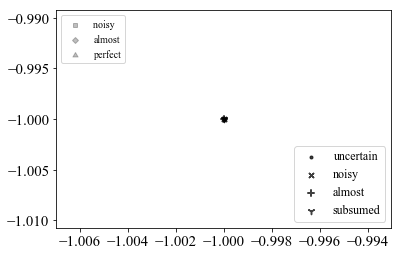

In [42]:
complete_metric_plot(minimal_data, ['LogLossSohier', 'LogLoss'], fn='all')

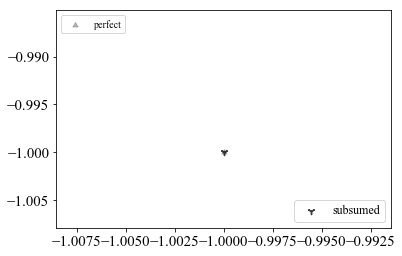

In [24]:
complete_metric_plot(upper_data, ['LogLossSohier', 'LogLoss'], fn='upper_zoom', xlims=(0., 19.5), ylims=(0., 19.5))

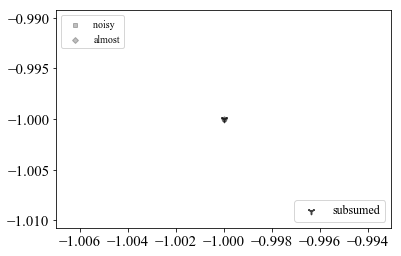

In [25]:
complete_metric_plot(middle_data, ['LogLossSohier', 'LogLoss'], fn='middle_zoom', xlims=(0., 1.75), ylims=(0., 1.75))

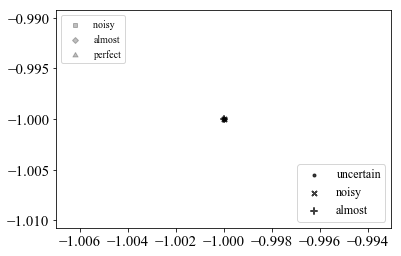

In [40]:
complete_metric_plot(lower_data, ['LogLossSohier', 'LogLoss'], fn='lower_zoom', xlims=(0., 20), ylims=(0., 20))

In [27]:
alt_mega_test = load_collector('fig/test'+str(M_classes)+'_fromcmdm.pkl')

In [28]:
for base in alt_mega_test.keys():
    for added in alt_mega_test[base].keys():
        numerator = alt_mega_test[base][added]['LogLoss']['10'][1] - alt_mega_test[base][added]['LogLoss']['0'][1]
        denominator = alt_mega_test[base][added]['LogLossSohier']['10'][1] - alt_mega_test[base][added]['LogLossSohier']['0'][1]
        minx = round(alt_mega_test[base][added]['LogLossSohier']['0'][1], 4)
        miny = round(alt_mega_test[base][added]['LogLoss']['0'][1], 4)
        maxx = round(alt_mega_test[base][added]['LogLossSohier']['10'][1], 4)
        maxy = round(alt_mega_test[base][added]['LogLoss']['10'][1], 4)
        minimum = (minx, miny)
        maximum = (maxx, maxy)
        print(base+' plus '+added)
        print('slope = '+str(round(numerator / denominator, 4)))
        print('extrema = '+str((minimum, maximum)))

perfect plus almost
slope = 1.0
extrema = ((0.0, 0.0), (1.4481, 1.4481))
perfect plus noisy
slope = 1.0
extrema = ((0.0, 0.0), (1.7726, 1.7726))
perfect plus uncertain
slope = 1.0
extrema = ((0.0, 0.0), (2.4208, 2.4208))
perfect plus subsumed
slope = 1.0
extrema = ((0.0, 0.0), (18.4207, 18.4207))
almost plus noisy
slope = 1.0
extrema = ((1.4009, 1.4009), (1.9364, 1.9364))
almost plus uncertain
slope = 1.0
extrema = ((1.4021, 1.4021), (2.6872, 2.6872))
almost plus subsumed
slope = 1.0
extrema = ((1.4029, 1.4029), (2.3398, 2.3398))
noisy plus uncertain
slope = 1.0
extrema = ((1.9907, 1.9907), (2.6395, 2.6395))
noisy plus subsumed
slope = 1.0
extrema = ((1.976, 1.976), (2.7863, 2.7863))
uncertain plus subsumed
slope = 1.0
extrema = ((2.6216, 2.6216), (2.9414, 2.9414))


In [29]:
order = ['upper', 'middle', 'lower']
lims = {}
lims['upper'] = (1.05, 19.5)
lims['middle'] = (0.675, 1.75)
lims['lower'] = (0.275, 0.75)
lims['all'] = (1.1, 20.)
boxcols = {}
boxcols['lower'] = '#D179F2'
boxcols['middle'] = '#F27979'
boxcols['upper'] = '#FFE17F'
boxcols['all'] = 'None'
multiscaledata = {}
multiscaledata['all'] = minimal_data
multiscaledata['upper'] = upper_data
multiscaledata['middle'] = middle_data
multiscaledata['lower'] = lower_data
titles = {}
titles['upper'] = 'subsumed systematic on perfect baseline'
titles['middle'] = 'subsumed systematic on non-perfect baselines'
titles['lower'] = 'non-subsumed systematics on all baselines'

In [38]:
def paneled_metric_plot(full_dataset, metric_names, order, lims, boxcols, titles, fn='multipanel_res'):

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset

    fig = pylab.figure(figsize=(17.5, 5))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxes.set_xlabel(metric_names[0], fontsize=20, labelpad=25)
    bigAxes.set_ylabel(metric_names[1], fontsize=20, labelpad=30)
    
    axupper = fig.add_subplot(131)
    
    axmiddle = inset_axes(axupper, width="100%", height="100%",
                   bbox_to_anchor=(1.10, 0., 1., 1.),
                   bbox_transform=axupper.transAxes, loc=2, borderpad=0)
    axmiddle.tick_params(left=True, right=False, labelleft=True, labelright=False)
    mark_inset(axupper, axmiddle, loc1=2, loc2=3, fc="none", ec="0.5")
    
    axlower = inset_axes(axmiddle, width="100%", height="100%",
                   bbox_to_anchor=(1.10, 0., 1., 1.),
                   bbox_transform=axmiddle.transAxes, loc=2, borderpad=0)
    axlower.tick_params(left=True, right=False, labelleft=True, labelright=False)
    mark_inset(axmiddle, axlower, loc1=2, loc2=3, fc="none", ec="0.5")
    
    allmyaxes = [axupper, axmiddle, axlower]
    
    for i in range(3):
        scale = order[i]
        ax = allmyaxes[i]
    
        dataset = full_dataset[scale]
        
        xlims = (-0.1 * lims[scale][0], lims[scale][0])
        ylims = (-0.1 * lims[scale][1], lims[scale][1])

        bases, additions = [], []
        for base in dataset.keys():# this is the base upon which a systematic was added
            if base != 'uncertain':
                bases.append(base + ' as baseline')
                for added in dataset[base].keys():# this is the systematic added on
                    additions.append(added + ' as systematic')
                    xvals = [dataset[base][added][metric_names[0]][str(i)][1] for i in range(11)]
                    yvals = [dataset[base][added][metric_names[1]][str(i)][1] for i in range(11)]
                    ax.scatter(xvals, yvals,
                      c=fave_cmap(np.flip(possible_weights)),
                      s=150.,
                      marker=all_shapes_bg[base],
                      alpha=0.25)
                    ax.scatter(xvals, yvals,
                      c=fave_cmap(possible_weights),
                      s=125.,
                      marker=all_shapes_fg[added],
                      alpha=0.5)
        ax.set_title(titles[order[i]], fontsize=17.5)
        bases = list(set(bases))
        additions = list(set(additions))
        all_labels = bases+additions
        b_handles, a_handles = [], []
        for base in bases:
            thing = ax.scatter(-1., -1., label=base, color='k', alpha=0.25, marker=all_shapes_bg[base[:-12]])
            b_handles.append(thing)

        for added in additions:
            thing = ax.scatter(-1., -1., label=added, color='k', alpha=0.75, marker=all_shapes_fg[added[:-14]])
            a_handles.append(thing)

        if i != 2:
            ax.legend(handles=b_handles+a_handles, loc='upper left', fontsize='large')
        else:
            axins = inset_axes(ax,
                    width="2%",  # width = 25% of parent_bbox width
                    height="90%",  # height : 5%
                    loc=4)
            mpl.colorbar.ColorbarBase(axins, cmap=fave_cmap,
                                norm=mpl.colors.Normalize(vmin=0., vmax=1.))

            axins.set_ylabel('Fractional Weight', rotation=270, labelpad=15., fontsize=15.)
            ax.legend(handles=b_handles+a_handles, loc='lower right', fontsize='large')
        if xlims is not None:
            ax.set_xlim(xlims[0], xlims[1])
        if ylims is not None:
            ax.set_ylim(ylims[0], ylims[1])
            
    plt.subplots_adjust()

    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    pylab.savefig('fig/'+fn+'.png', dpi=250)
    pylab.show()
    return

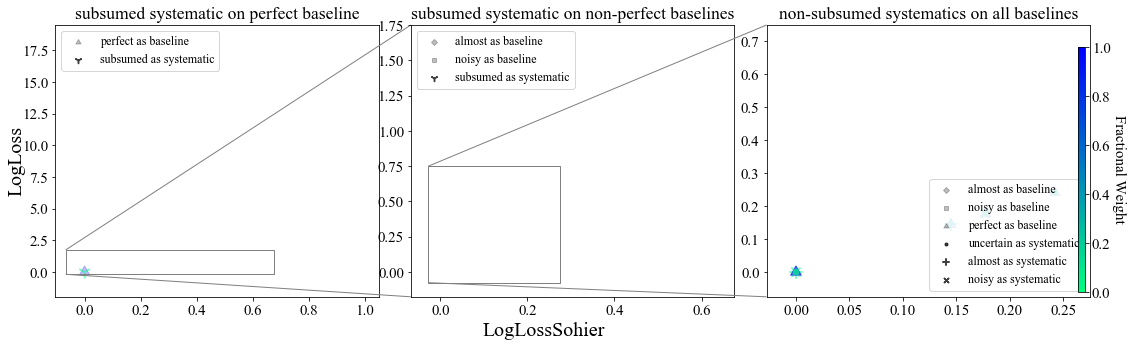

In [39]:
paneled_metric_plot(multiscaledata, ['LogLossSohier', 'LogLoss'], order, lims, boxcols, titles, fn='multipanel_res')

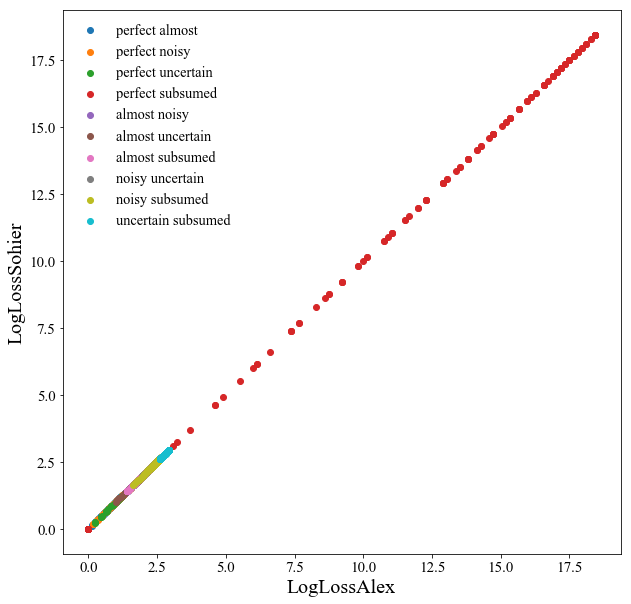

In [63]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
all_x = []
all_y = []
for classifier in alt_mega_test:
    for systematic in alt_mega_test[classifier]:
        x = []
        y = []
        for wt in alt_mega_test[classifier][systematic]['LogLoss']:
            x += alt_mega_test[classifier][systematic]['LogLoss'][wt].tolist()
            y += alt_mega_test[classifier][systematic]['LogLossSohier'][wt].tolist()
        ax.scatter(x, y, marker='o', label=f'{classifier} {systematic}')
        all_x += x
        all_y += y
ax.set_xlabel('LogLossAlex')
ax.set_ylabel('LogLossSohier')
ax.legend(frameon =False, loc='upper left', fontsize='x-large')
all_x = np.array(all_x)
all_y = np.array(all_y)
fig.savefig('fig/metric_comparison.png')

In [64]:
np.allclose(all_x, all_y)

True

In [66]:
np.max(np.abs(all_x - all_y))

7.105427357601002e-15